In [1]:
import numpy as np
from facenet_models import FacenetModel
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import text
import skimage.io as io
from PIL import Image

TypeError: 'type' object is not subscriptable

In [3]:
import torch
if (torch.cuda.is_available()):
	print("Using GPU")
	device = torch.device("cuda")

Using GPU


In [4]:
def find_eyes(image_data, *, box_threshold=0.97):
    """
    Displays an image with boxes around people's faces and labels them with names.
    Parameters
    ----------
    image_data : numpy.ndarray, shape-(R, C, 3) (RGB is the last dimension)
        Pixel information for the image.
    """
    model = FacenetModel()
    boxes, probabilities, landmarks = model.detect(image_data)

    fig, ax = plt.subplots()
    ax.imshow(image_data)
    if (boxes is None):
        x = image_data.shape[1] // 2
        y = image_data.shape[0] // 2
        ax.text(x, y,
                "GIMME A FACE",
                size=50,
                va="center",
                ha="center",
                bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
        plt.show()
        return
    descriptors = model.compute_descriptors(image_data, boxes)

    for box, prob, i in zip(boxes, probabilities, range(len(names))):
        if prob<box_threshold:
            continue
        # draw the box on the screen
        ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))
        
        # Get the landmarks/parts for the face in box d.
        # Draw the face landmarks on the screen.
        for i in range(len(landmark)):
            ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")
    # plt.show()

Filepath: ../../CogWorks-2022-Gausslien-Vision-Capstone/Loaded_Images/alan_0.png


C:\Users\evan_\.conda\envs\GPUTorch\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "Min":
C:\Users\evan_\.conda\envs\GPUTorch\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "Min":
C:\Users\evan_\.conda\envs\GPUTorch\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "Min":


NameError: name 'cv2' is not defined

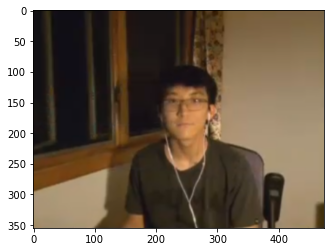

In [5]:
filepath = input("Filepath: ")
# pic = np.array(Image.open(filepath))[:,:,:3]
# shape-(Height, Width, Color)
pic = io.imread(str(filepath))
if pic.shape[-1] == 4:
    # Image is RGBA, where A is alpha -> transparency
    # Must make image RGB.
    pic = pic[..., :-1]  # png -> RGB
find_eyes(pic)